# To predict in vivo TF binding

Features extracted from:
Motif scanning
MNase-seq
RNA-seq

Gene annotation
Cell lines:
A-549
MCF-7
HepG2
K562
HeLa-S3

Held out chrs (did not have the label file):
chr1
chr8
chr20
New held out chrs: chr2

In [1]:
# Modules

# import regular expression module
import re

# import sys module
import sys

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna
import pandas as pd
import math

import matplotlib.pyplot as plt

# machine learning
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score, accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np
from sklearn.cross_validation import cross_val_score, cross_val_predict
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFdr

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
##################################################################
##################################################################
# functions

In [3]:
def recall_at_fdr(y_true, y_pred, fdr_cutoff1=0.05, fdr_cutoff2=0.1, fdr_cutoff3=0.25,fdr_cutoff4=0.5):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    fdr = 1- precision
    cutoff_index1 = next(i for i, x in enumerate(fdr) if x <= fdr_cutoff1)
    cutoff_index2 = next(i for i, x in enumerate(fdr) if x <= fdr_cutoff2)
    cutoff_index3 = next(i for i, x in enumerate(fdr) if x <= fdr_cutoff3)
    cutoff_index4 = next(i for i, x in enumerate(fdr) if x <= fdr_cutoff4)
    return (recall[cutoff_index1],recall[cutoff_index2],recall[cutoff_index3],recall[cutoff_index4])

In [4]:
def log_reg(X_train,Y_train,X_test,Y_test,cellline):
    # Logistic Regression
    logreg = LogisticRegression()
    logreg.fit(X_train, Y_train)
    Y_pred = logreg.predict_proba(X_test)
    # calculating auc
    precision, recall, thresholds = precision_recall_curve(Y_test,Y_pred[:,1])
    area = auc(recall,precision,reorder=True)
    prc_log='{:.4f}'.format(area)
    fpr, tpr, threshold = roc_curve(Y_test, Y_pred[:,1])
    log_roc_auc = auc(fpr, tpr)
    # plot ROC curve
    plt.figure()
    plt.title('Logistic Regression ROC curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % log_roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    f = open(cellline+'_log_roc.png', 'wb')
    plt.savefig(cellline+'_log_roc.png')
    f.close()
    # Plot Precision-Recall curve
    plt.figure()
    plt.clf()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Logistic Regression PRC={0:0.4f}'.format(area))
    plt.legend(loc="lower left")
    f = open(cellline+'_log_prc.png', 'wb')
    plt.savefig(cellline+'_log_prc.png')
    f.close()
    # calculate recalls
    log_fdr_5pct, log_fdr_10pct, log_fdr_25pct, log_fdr_50pct=recall_at_fdr(Y_test,Y_pred[:,1])
    return (prc_log,log_roc_auc,log_fdr_5pct,log_fdr_10pct,log_fdr_25pct,log_fdr_50pct)

In [5]:
def xgboost_train(X_train,Y_train,X_test,Y_test,cellline, scale):
    model = XGBClassifier(n_estimators=75, subsample=1, seed=1996, gamma=0,objective='binary:logistic',
                      scale_pos_weight=scale,max_depth=7, min_child_weight=7,nthread=20)
    model.fit(X_train, Y_train)
    predictions = model.predict_proba(X_test)
    precision, recall, thresholds = precision_recall_curve(Y_test, predictions[:,1])
    area = auc(recall,precision)
    prc_xgboost='{:.4f}'.format(area)
    fpr, tpr, threshold = roc_curve(Y_test, predictions[:,1])
    xg_roc_auc = auc(fpr, tpr)
    # Plot Precision-Recall curve
    plt.figure()
    plt.title('XGboost ROC curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % xg_roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    f = open(cellline+'_xgboost_roc.png', 'wb')
    plt.savefig(cellline+'_xgboost_roc.png')
    f.close()
    # Plot Precision-Recall curve
    plt.figure()
    plt.clf()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('XGboost PRC={0:0.4f}'.format(area))
    plt.legend(loc="lower left")
    f = open(cellline+'_xgboost_prc.png', 'wb')
    plt.savefig(cellline+'_xgboost_prc.png')
    f.close()
    # calculate recalls
    xg_fdr_5pct, xg_fdr_10pct, xg_fdr_25pct, xg_fdr_50pct=recall_at_fdr(Y_test,predictions[:,1])
    return (prc_xgboost,xg_roc_auc,xg_fdr_5pct, xg_fdr_10pct, xg_fdr_25pct, xg_fdr_50pct)


In [6]:
def gau_train(X_train,Y_train,X_test,Y_test,cellline):
    gaussian = GaussianNB()
    gaussian.fit(X_train, Y_train)
    Y_pred = gaussian.predict_proba(X_test)
    # calculating auc
    precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred[:,1])
    area = auc(recall,precision)
    prc_gaussian='{:.4f}'.format(area)
    fpr, tpr, threshold = roc_curve(Y_test, Y_pred[:,1])
    gau_roc_auc = auc(fpr, tpr)
    # plot ROC curve
    plt.figure()
    plt.title('Gaussian Naive Bayes ROC curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % gau_roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    f = open(cellline+'_gau_roc.png', 'wb')
    plt.savefig(cellline+'_gau_roc.png')
    f.close()
    # plot Precision-Recall curve
    plt.figure()
    plt.clf()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Gaussian Naive Bayes PRC={0:0.4f}'.format(area))
    plt.legend(loc="lower left")
    f = open(cellline+'_gau_prc.png', 'wb')
    plt.savefig(cellline+'_gau_prc.png')
    f.close()
    # calculate recalls
    gau_fdr_5pct, gau_fdr_10pct, gau_fdr_25pct, gau_fdr_50pct=recall_at_fdr(Y_test,Y_pred[:,1])
    return (prc_gaussian,gau_roc_auc,gau_fdr_5pct,gau_fdr_10pct,gau_fdr_10pct,gau_fdr_25pct,gau_fdr_50pct)

In [7]:
def knn_train(X_train,Y_train,X_test,Y_test,cellline):
    # KNN
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict_proba(X_test)
    # calculating auc
    precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred[:,1])
    area = auc(recall,precision,reorder=True)
    prc_knn='{:.4f}'.format(area)
    fpr, tpr, threshold = roc_curve(Y_test, Y_pred[:,1])
    knn_roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.title('KNN ROC curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % knn_roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    f = open(cellline+'_knn_roc.png', 'wb')
    plt.savefig(cellline+'_knn_roc.png')
    f.close()
    # plot Precision-Recall curve
    plt.figure()
    plt.clf()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('KNN PRC={0:0.4f}'.format(area))
    plt.legend(loc="lower left")
    f = open(cellline+'_knn_prc.png', 'wb')
    plt.savefig(cellline+'_knn_prc.png')
    f.close()
    # calculate recalls
    knn_fdr_5pct, knn_fdr_10pct, knn_fdr_25pct, knn_fdr_50pct=recall_at_fdr(Y_test,Y_pred[:,1])
    return (prc_knn,knn_roc_auc,knn_fdr_5pct,knn_fdr_10pct,knn_fdr_25pct,knn_fdr_50pct)


In [8]:
def decision_tree_train(X_train,Y_train,X_test,Y_test,cellline):
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(X_train, Y_train)
    Y_pred = decision_tree.predict_proba(X_test)
    precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred[:,1])
    area = auc(recall,precision)
    prc_decision_tree='{:.4f}'.format(area)
    fpr, tpr, threshold = roc_curve(Y_test, Y_pred[:,1])
    dt_roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.title('Decision Tree ROC curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % dt_roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    f = open(cellline+'_dt_roc.png', 'wb')
    plt.savefig(cellline+'_dt_roc.png')
    f.close()
    # Plot Precision-Recall curve
    plt.figure()
    plt.clf()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Decision Tree PRC={0:0.4f}'.format(area))
    plt.legend(loc="lower left")
    f = open(cellline+'_dt_prc.png', 'wb')
    plt.savefig(cellline+'_dt_prc.png')
    f.close()
    # calculate recalls
    dt_fdr_5pct, dt_fdr_10pct, dt_fdr_25pct, dt_fdr_50pct=recall_at_fdr(Y_test,Y_pred[:,1])
    return (prc_decision_tree, dt_roc_auc, dt_fdr_5pct,dt_fdr_10pct,dt_fdr_25pct,dt_fdr_50pct)


In [9]:
def random_forest_train(X_train,Y_train,X_test,Y_test,cellline):
    # Random Forest
    random_forest = RandomForestClassifier(n_estimators=100)
    random_forest.fit(X_train, Y_train)
    Y_pred = random_forest.predict_proba(X_test)
    precision, recall, thresholds = precision_recall_curve(Y_test, Y_pred[:,1])
    area = auc(recall,precision)
    prc_random_forest='{:.4f}'.format(area)
    fpr, tpr, threshold = roc_curve(Y_test, Y_pred[:,1])
    rf_roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.title('Random Forest ROC curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % rf_roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    f = open(cellline+'_rf_roc.png', 'wb')
    plt.savefig(cellline+'_rf_roc.png')
    f.close()
    # Plot Precision-Recall curve
    plt.figure()
    plt.clf()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Random Forest PRC={0:0.4f}'.format(area))
    plt.legend(loc="lower left")
    f = open(cellline+'_rf_prc.png', 'wb')
    plt.savefig(cellline+'_rf_prc.png')
    f.close()
    # calculate recalls
    rf_fdr_5pct, rf_fdr_10pct, rf_fdr_25pct, rf_fdr_50pct=recall_at_fdr(Y_test,Y_pred[:,1])
    return (prc_random_forest, rf_roc_auc, rf_fdr_5pct,rf_fdr_10pct,rf_fdr_25pct,rf_fdr_50pct)

In [19]:
def neural_network(X_train,Y_train,X_test,Y_test,cellline):
    # preprocessing alldata
    scaler = StandardScaler()
    scaler.fit(X_train)
    # Now apply the transformations to the data
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    mlp = MLPClassifier(hidden_layer_sizes=(35,100,35),max_iter=200)
    mlp.fit(X_train,Y_train)
    predictions=mlp.predict_proba(X_test)
    precision, recall, thresholds = precision_recall_curve(Y_test, predictions[:,1])
    area = auc(recall,precision)
    prc_nn=' {:.4f}'.format(area)
    fpr, tpr, threshold = roc_curve(Y_test, predictions[:,1])
    nn_roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.title('Neural Network ROC curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % nn_roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    f = open(cellline+'_nn_roc.png', 'wb')
    plt.savefig(cellline+'_nn_roc.png')
    f.close()
    # Plot Precision-Recall curve
    plt.figure()
    plt.clf()
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Neural Network PRC={0:0.4f}'.format(area))
    plt.legend(loc="lower left")
    f = open(cellline+'_nn_prc.png', 'wb')
    plt.savefig(cellline+'_nn_prc.png')
    f.close()
    # calculate recalls
    nn_fdr_5pct, nn_fdr_10pct, nn_fdr_25pct, nn_fdr_50pct=recall_at_fdr(Y_test,predictions[:,1])
    return (prc_nn,nn_roc_auc,nn_fdr_5pct,nn_fdr_10pct,nn_fdr_25pct,nn_fdr_50pct)

In [40]:
# read in the data
train=pd.read_csv('/Users/sunnysun/Desktop/K562_train_1to10_2.txt',sep='\t',header=0)
test=pd.read_csv('/Users/sunnysun/Desktop/dream_test/combine/K562_new_combined_features_071_noA_rmna.txt',sep='\t',header=0)
cellline='K562'
col=pd.read_csv('/Users/sunnysun/Desktop/dream_test/K562_new_combined_features_000.txt',sep='\t',header=0)
train.columns=col.columns
test.columns=col.columns
train=train.drop("chr",axis=1)
train=train.drop("start",axis=1)
train=train.drop("end",axis=1)
test=test.drop("chr",axis=1)
test=test.drop("start",axis=1)
test=test.drop("end",axis=1)
# convert the categorical data to numeric
s = pd.Series(train[cellline])
s=s.replace({'B': 1})
s=s.replace({'U': 0})
train[cellline]=s
s = pd.Series(test[cellline])
s=s.replace({'B': 1})
s=s.replace({'U': 0})
test[cellline]=s
X_train = train.drop(cellline, axis=1)
Y_train = train[cellline]
X_test  = test.drop(cellline, axis=1)
Y_test = test[cellline]

In [36]:
# running the functions
(prc_log,log_roc_auc,log_fdr_5pct,log_fdr_10pct,log_fdr_25pct,log_fdr_50pct)=log_reg(X_train,Y_train,X_test,Y_test,cellline)

ValueError: unknown format is not supported

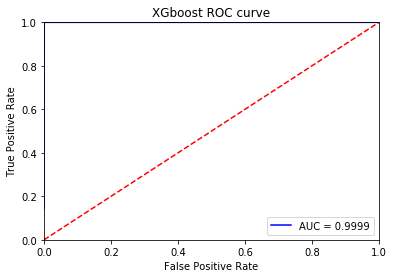

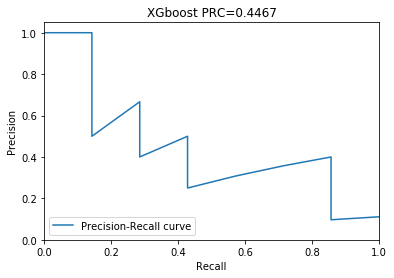

In [30]:
scale=10
(prc_xgboost,xg_roc_auc,xg_fdr_5pct,xg_fdr_10pct,xg_fdr_25pct,xg_fdr_50pct)=xgboost_train(X_train,Y_train,X_test,Y_test,cellline,scale)

In [ ]:
(prc_knn,knn_roc_auc,knn_fdr_5pct,knn_fdr_10pct,knn_fdr_25pct,knn_fdr_50pct)=knn_train(X_train,Y_train,X_test,Y_test,cellline)

In [39]:
(prc_gaussian,gau_roc_auc,gau_fdr_5pct,gau_fdr_10pct,gau_fdr_10pct,gau_fdr_25pct,gau_fdr_50pct)=gau_train(X_train,Y_train,X_test,Y_test,cellline)

ValueError: unknown format is not supported

In [ ]:
(prc_decision_tree, dt_roc_auc, dt_fdr_5pct,dt_fdr_10pct,dt_fdr_25pct,dt_fdr_50pct)=decision_tree_train(X_train,Y_train,X_test,Y_test,cellline)

In [ ]:
(prc_random_forest, rf_roc_auc, rf_fdr_5pct,rf_fdr_10pct,rf_fdr_25pct,rf_fdr_50pct)=random_forest_train(X_train,Y_train,X_test,Y_test,cellline)

In [ ]:
(prc_nn,nn_roc_auc,nn_fdr_5pct,nn_fdr_10pct,nn_fdr_25pct,nn_fdr_50pct)=neural_network(X_train,Y_train,X_test,Y_test,cellline)

In [ ]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes','Decision Tree','Neural Network','XGboost'],
    'auROC': [knn_roc_auc, log_roc_auc, rf_roc_auc, gau_roc_auc, dt_roc_auc, nn_roc_auc, xg_roc_auc],
    'auPRC': [prc_knn,prc_log,prc_random_forest,prc_gaussian,prc_decision_tree, prc_nn, prc_xgboost],
    'Recall at 5%FDR':[knn_fdr_5pct,log_fdr_5pct,rf_fdr_5pct,gau_fdr_5pct,dt_fdr_5pct,nn_fdr_5pct,xg_fdr_5pct],
    'Recall at 10%FDR':[knn_fdr_10pct,log_fdr_10pct,rf_fdr_10pct,gau_fdr_10pct,dt_fdr_10pct,nn_fdr_10pct,xg_fdr_10pct],
    'Recall at 25%FDR':[knn_fdr_25pct,log_fdr_25pct,rf_fdr_25pct,gau_fdr_25pct,dt_fdr_25pct,nn_fdr_25pct,xg_fdr_25pct],
    'Recall at 50%FDR':[knn_fdr_50pct,log_fdr_50pct,rf_fdr_50pct,gau_fdr_50pct,dt_fdr_50pct,nn_fdr_50pct,xg_fdr_50pct]
                        })
models=models[['Model','auROC','auPRC','Recall at 5%FDR','Recall at 10%FDR','Recall at 25%FDR','Recall at 50%FDR']]
models.sort_values(by='auROC', ascending=False)